# Analysis of Life Expectancy Based on Localization in Lucas County

## Introduction

This project analyzed the effects of economic data (such as income and distance from downtown Toledo) on life 
expectancy per census tract in Lucas County. The data for this project was collected from the U.S. Small-area Life 
Expectancy Estimates Project (USALEEP) and the US Census Bureau. 

The method of analysis was multivariate ordinary least squares regression. After running a regression, it was shown 
that the income was the most economically significant outcome, as an additional $10,000 in income will lead to about 
an extra half a year (.48 years) of life expectancy on average, all else held constant.


In [11]:
import time

import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook

In [32]:
# import base data
counties = pd.read_csv("./data/OH_county_codes.txt", 
                       delimiter=",", header=None, index_col=None,
                       dtype={0: str, 1: str, 2: str, 3: str, 4: str})
# rename the columns
counties.rename(index=str, columns={0: "State", 1: "State Code", 2: "County Code", 3: "County"}, inplace=True)

msa_codes = pd.read_excel("./data/msa_codes.xlsx", 
                          index_col=None)


Now lets get a glimpse of the data we're looking at:

In [14]:
# locate Lucas County county code
county = "Lucas County"
lc_code_row = counties.loc[counties["County"] == county]
print(lc_code_row.head())

   State State Code County Code        County   4
47    OH         39         095  Lucas County  H1


In [33]:
# load life expectancy data
life_expectancy = pd.read_excel("./data/OH_life_expectancy.xlsx", 
                                index_col=None, dtype={"TractID": str, "CNTY2KX": str, "TRACT2KX": str})
print(life_expectancy.head())
print()
print(life_expectancy["e(0)"].describe())

      Tract ID  STATE2KX CNTY2KX TRACT2KX  e(0)  se(e(0))  \
0  39001770100        39     001   770100  74.2    1.3400   
1  39001770200        39     001   770200  75.7    1.3629   
2  39001770300        39     001   770300  75.7    1.0976   
3  39001770500        39     001   770500  72.5    1.5207   
4  39001770600        39     001   770600  72.0    1.3962   

   Abridged life table flag  
0                         3  
1                         3  
2                         1  
3                         3  
4                         3  

count    2772.000000
mean       76.567100
std         4.083077
min        60.000000
25%        73.900000
50%        76.900000
75%        79.525000
max        89.200000
Name: e(0), dtype: float64


In [34]:
# load tract lat,lon data
lat_lon = pd.read_excel("./data/OH_tracts_lat_long.xlsx", 
                        index_col=None, dtype={"INTPTLAT": str, "INTPTLONG": str})
print(lat_lon.head())

  USPS        GEOID  POP10  HU10      ALAND   AWATER  ALAND_SQMI  AWATER_SQMI  \
0   OH  39001770100   4864  2210  286773444  1535839     110.724        0.593   
1   OH  39001770200   4815  2053  222681673   102314      85.978        0.040   
2   OH  39001770300   6964  2891  389162277   170790     150.256        0.066   
3   OH  39001770400   4948  2243   96475789   242467      37.250        0.094   
4   OH  39001770500   3442  1741  394801572  1580113     152.434        0.610   

     INTPTLAT    INTPTLONG  
0  38.9558932  -83.3556109  
1  38.9909749  -83.5518337  
2  38.8403307  -83.5815269  
3   38.771614  -83.5445148  
4  38.7507829  -83.3646628  


## Prepping Tracts

Now that we have the county code for Lucas County, we can now find all the life expectancies for each tract,
and extract out their relevant values from the life expectancy data.

In [17]:
# get tracts that are in Lucas County
expectancy = life_expectancy.loc[life_expectancy["CNTY2KX"] == lc_code_row.iloc[0]["County Code"]]

# get values for each tract
track = expectancy["TRACT2KX"].values
county_codes = expectancy["CNTY2KX"].values
geoids = expectancy["Tract ID"].values
expectancy = expectancy["e(0)"].values

# format the tract values
for i, row_ in enumerate(track):
    value = row_[0:4] + "." + row_[4:]
    track[i] = value

## Getting Census Data

Now that we have all the life expectancy data and their associated tract numbers, we can retrieve census data
about each tract to use as potential factors in explaining the life expectancy values.

In [18]:
# Split the county name up 
split_county = county.split()

# get the extra data from the Census website
tract_info = {}
for track_num in tqdm_notebook(range(len(track)), desc='Tracks'):
    time.sleep(5)
    demo_string = f"https://geomap.ffiec.gov/FFIECGeocMap/CensusDemo.aspx?" \
                  f"sMSACode=45780&" \
                  f"sStateCode={lc_code_row.iloc[0]['State Code']}&s" \
                  f"CountyCode={lc_code_row.iloc[0]['County Code']}&" \
                  f"sTractCode={track[track_num]}&" \
                  f"iCensYear=2018&" \
                  f"sAddress=Selected%20Tract&" \
                  f"sMSAName=TOLEDO,%20OH&" \
                  f"sStateName2=OHIO&" \
                  f"sCountyName={split_county[0].upper()}%20{split_county[1].upper()}"
    
    r = requests.get(demo_string)

    if r.status_code == 200:
        soup = BeautifulSoup(r.content, 'html.parser')
        tables_ = soup.find_all('div', class_='container1')
        
        labels, data = [], []

        # GEOID
        labels.append("GEOID")
        data.append(str(geoids[track_num]))

        for i, item in enumerate(soup.find_all('div', class_='table-row')):
            label = item.find(class_="censcol1p").get_text().strip('\n')
            value = item.find("div", class_="censcol2p").get_text().strip('\n')

            labels.append(str(label))
            data.append(str(value))

        lat_lon_row = lat_lon.loc[lat_lon["GEOID"] == geoids[track_num]]

        # latitude, longitude, life expectancy
        labels += ["lat",
                   "long",
                   "life_expectancy"]
        data   += [lat_lon_row.iloc[0]["INTPTLAT"], 
                   lat_lon_row.iloc[0]["INTPTLONG"], 
                   expectancy[track_num]]

        table = pd.DataFrame.from_dict({"label": labels, "value": data})
        # remove any duplicate rows (of which there are several
        table.drop_duplicates(inplace=True)
        
        tract_info[track[track_num]] = table

## Transpose and Add Distance Information

We now use the latitude and longitude values to compute the distance from downtown Toledo. In this case,
I chose the Huntington Center as my marker for the rough "middle" of the downtown area. This will serve 
as a metric as a distance from the inner city.

We then transpose the data so that we can have all our information in one single table.

In [21]:
from geopy.distance import distance

In [22]:
# prep the labels for the transposed data
table = tract_info[list(tract_info.keys())[0]]
table_labels = list(table["label"].values)
# skip over lat and long as we replace them with distance
table_labels = table_labels[0:29] + table_labels[31:]
table_labels.insert(29, "distance")

transp_data = []
# transpose the data
for j, file in enumerate(tract_info.keys()):
    table = tract_info[file]
    table = table.set_index('label')

    data_ = list(table["value"].values)
    # skip over lat and long as we replace them with distance
    data_ = data_[0:29] + data_[31:]

    # Huntington Center
    toledo = (41.6498596, -83.5372281)
    tract = (float(table.loc["lat"].values), float(table.loc["long"].values))
    distance_ = distance(toledo, tract).mi
    data_.insert(29, distance_)

    transp_data.append(data_)
    
transp_data = pd.DataFrame(transp_data, columns=table_labels)
print(transp_data.head())

         GEOID Tract Income Level Underserved or Distressed Tract  \
0  39095000200             Middle                              No   
1  39095000300             Middle                              No   
2  39095000400           Moderate                              No   
3  39095000600             Middle                              No   
4  39095000700           Moderate                              No   

  2018 FFIEC Estimated MSA/MD/non-MSA/MD Median Family Income  \
0                                            $67,200            
1                                            $67,200            
2                                            $67,200            
3                                            $67,200            
4                                            $67,200            

  2018 Estimated Tract Median Family Income 2010 Tract Median Family Income  \
0                                   $66,179                         $59,611   
1                                   

## Prepare GeoJSON Data

From the state of Ohio, select only the GeoJSON data for the tracts we have values for (Lucas County).

In [23]:
import json

In [35]:
# process geoJSON
with open('./data/OH_geojson_tract.json', "r") as f:
    tracts = json.load(f)

new_geo = {"features": [],
           "type": "FeatureCollection"}

for geo in tracts["features"]:
    geo_id = geo["properties"]["GEOID"]

    if str(geo_id) in list(transp_data["GEOID"].values.astype(str)):
        new_geo["features"].append(geo)

geo_tract_info = new_geo

KeyError: 'GEOID'

## Plot the Map

Now we plot a map of our life expectancy data using shapes from a geoJSON file and using
GEOpandas.

In [26]:
import matplotlib.pyplot as plt
import geopandas as gpd

      ALAND   AWATER COUNTYFP FUNCSTAT        GEOID     INTPTLAT  \
0   2540639   393134      095        S  39095010300  +41.6372086   
1   2752789        0      095        S  39095010200  +41.6191875   
2  67527577  1268718      095        S  39095009600  +41.4697537   
3   4356469   119955      095        S  39095000900  +41.6922491   
4   2219009        0      095        S  39095003900  +41.6322054   

       INTPTLON  MTFCC NAME          NAMELSAD STATEFP TRACTCE  \
0  -083.5433566  G5020  103  Census Tract 103      39  010300   
1  -083.5989422  G5020  102  Census Tract 102      39  010200   
2  -083.8364205  G5020   96   Census Tract 96      39  009600   
3  -083.5413962  G5020    9    Census Tract 9      39  000900   
4  -083.5926945  G5020   39   Census Tract 39      39  003900   

                                            geometry  
0  POLYGON ((-83.557496 41.641439, -83.557338 41....  
1  POLYGON ((-83.606549 41.62398, -83.60610899999...  
2  POLYGON ((-83.882943 41.487543, 

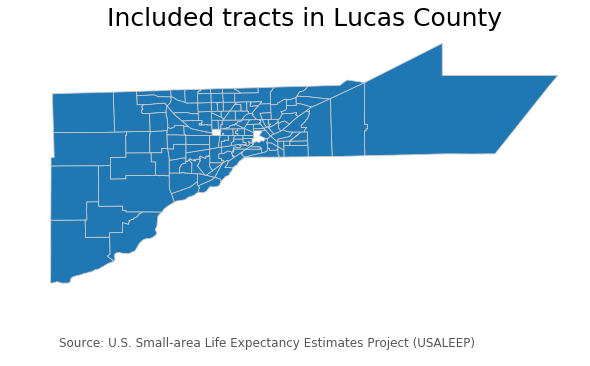

In [27]:
# load in GeoJSON
map_df = gpd.GeoDataFrame.from_features(geo_tract_info)
print(map_df.head())

map_df["GEOID"] = pd.to_numeric(map_df["GEOID"])
map_df = map_df.set_index("GEOID")

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

map_df.plot(ax=ax, linewidth=0.8, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Included tracts in Lucas County",
             fontdict={"fontsize": "25", "fontweight": "3"})
# create an annotation
ax.annotate("Source: U.S. Small-area Life Expectancy Estimates Project (USALEEP)",
            xy=(0.1, .08),
            xycoords="figure fraction",
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=12,
            color="#555555")

plt.show()

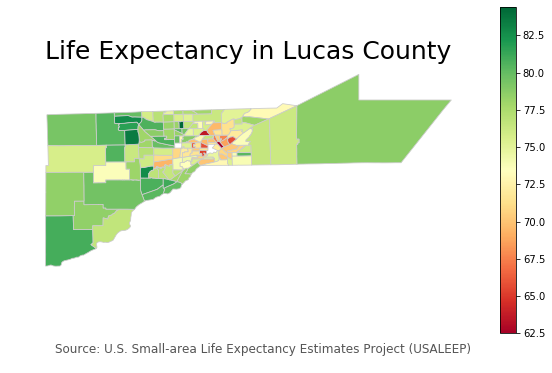

In [28]:
transp_data = transp_data.copy()
transp_data["GEOID"] = pd.to_numeric(transp_data["GEOID"])
transp_data = transp_data.set_index("GEOID")

merged = map_df.join(transp_data)
merged = merged.dropna()

# set a variable that will call whatever column we want to visualise on the map
variable = "life_expectancy"
# set the range for the choropleth
vmin, vmax = transp_data["life_expectancy"].min(), transp_data["life_expectancy"].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
merged.plot(column=variable, cmap=plt.cm.RdYlGn, linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Life Expectancy in Lucas County",
             fontdict={"fontsize": "25", "fontweight": "3"})
# create an annotation for the data source
ax.annotate("Source: U.S. Small-area Life Expectancy Estimates Project (USALEEP)",
            xy=(0.1, .08),
            xycoords="figure fraction",
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=12,
            color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
plt.show()

## Plot the Correlation Coefficients

2018 FFIEC Estimated MSA/MD/non-MSA/MD Median Family Income and 2010 MSA/MD/statewide non-MSA/MD Median Family Income 
are constant median incomes that I removed from the regression as they were not useful in the context of a regression. 

Due to the high dimensionality of the input space relative to the number of examples (27 variables, 123 examples) it 
was necessary to weed out features that had high correlation coefficients, as there was substantial multicollinearity 
between many factors.  

I decided to use percentage minority factors rather than raw minority number factors and looked at them percentage 
wise of tract population instead as this will likely be more informative to the model it is then a combination of
tract population and minority population so no interaction term is needed. This led to me realizing that non-black 
minorities were extremely small, and the black population percentage was essentially the inverse of the white 
population percentage, so no real additional data was added by including the minority percentage factors. 
Finally, Underserved or Distressed Tract (Discrete) was not included as all its values were 0.

In [29]:
import statsmodels.api as sm
import numpy as np

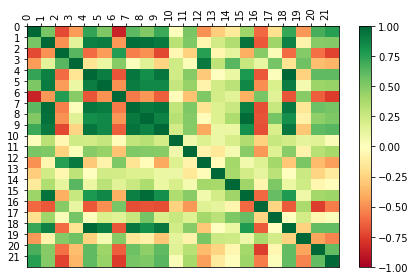

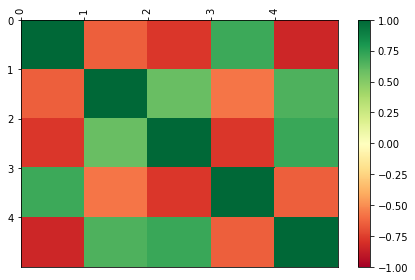

In [30]:
def visualize_data(df):
    df_corr = df.corr()
    df_corr.head()

    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)

    ax.set_xticks(np.arange(data.shape[0]), minor=False)
    ax.set_yticks(np.arange(data.shape[1]), minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()


tract_data = transp_data.copy()
tract_data = tract_data.apply(pd.to_numeric, errors='ignore')
tract_data = tract_data.reset_index()

tract_data = tract_data.drop(["GEOID",
                              "Tract Income Level",
                              "Underserved or Distressed Tract",
                              "Inside Principal City?",
                              "2018 FFIEC Estimated MSA/MD/non-MSA/MD Median Family Income",
                              "2010 MSA/MD/statewide non-MSA/MD Median Family Income"], axis=1)

visualize_data(tract_data)

tract_data["% White Population"] = tract_data["Non-Hispanic White Population"] / tract_data["Tract Population"]
tract_data["% Black Population"] = tract_data["Black Population"] / tract_data["Tract Population"]

tract_data["% Vacant Units"] = tract_data["Vacant Units"] / tract_data["Total Housing Units"]
tract_data["% Owner-Occupied Units"] = tract_data["Owner-Occupied Units"] / tract_data["Total Housing Units"]

tract_data = tract_data.drop(["2010 Tract Median Family Income",
                              "Tract Median Family Income %",
                              "Number of Families",
                              "Number of Households",
                              "2010 Tract Median Household Income",
                              "Owner Occupied 1- to 4- Family Units",
                              "Total Housing Units",
                              'American Indian Population',
                              'Asian/Hawaiian/Pacific Islander Population',
                              'Black Population',
                              'Hispanic Population',
                              'Other/Two or More Races Population',
                              "1- to 4- Family Units",
                              "Median House Age (Years)",
                              "Renter Occupied Units",
                              "% Black Population",
              
                              "Vacant Units",
                              "Owner-Occupied Units",
                              "Tract Population",
                              "Tract Minority Population",
                              "Non-Hispanic White Population",
                              "Tract Minority %"], axis=1)

tract_data.rename(columns={'2018 Estimated Tract Median Family Income': '2018 Median Income'}, inplace=True)
visualize_data(tract_data.drop(["life_expectancy"], axis=1))

## OLS Regression

The factors that are statistically significant at the 0.05 level are:
* 2018 Estimated Tract Median Family Income (0.003)
* % Vacant Units (0.000)
* 71.1% of variation in life expectancy is explained by these factors.

There are some interesting findings in this data, mainly being that income has a very large impact on life expectancy. 
As shown above, on average, all else held constant, a \$1 increase in income increases life expectancy by 4.83E-05 years,
which seems very small. Scaling that up however, it becomes clear that this has a large impact on life expectancy as 
on average, all else held constant, an increase in income of $10,000 will add .483 years on to your life. This shows 
that potentially getting a promotion can increase your life by a good bit.

Secondly, % vacant units can also have a large effect on life expectancy as well. On average, all else held constant, 
a 1% increase in vacant units can decrease life expectancy by ~14 years, which is rather significant. This is highly 
negatively correlated with % white population, which shows that in primary minority areas, there are more vacant units, 
resulting lower health outcomes for minority populations. This variable is likely picking up on many unobserved/omitted 
variables, as vacant units by themselves don’t affect life expectancy. Vacant units are likely indicative of a poor 
overall neighborhood environment, and all these factors together are being picked up by % vacant lots, resulting in 
the shown dramatic decrease in life expectancy when all factors are combined.

While the rest of the factors are interesting, they are not significant at the 5% level and 
more data would likely need to be collected.


In [31]:
tract_data["intercept"] = pd.Series(np.ones(tract_data.shape[0]))

tract_data['2018 Median Income'] = tract_data['2018 Median Income'].str.replace(',', '')
tract_data['2018 Median Income'] = tract_data['2018 Median Income'].str.replace('$', '')
tract_data['2018 Median Income'] = tract_data['2018 Median Income'].astype(int)
tract_data.apply(pd.to_numeric)

reg1 = sm.OLS(endog=tract_data["life_expectancy"], 
              exog=tract_data.drop(["life_expectancy"], axis=1), 
              missing='drop')

results = reg1.fit()

print(results.summary(alpha=0.05))
print()

reg1 = sm.OLS(endog=tract_data['life_expectancy'], 
              exog=tract_data.filter(["2018 Median Income", "intercept"]), 
              missing='drop')

results = reg1.fit()

print(results.summary(alpha=0.05))

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     47.58
Date:                Sun, 14 Jul 2019   Prob (F-statistic):           4.84e-29
Time:                        10:47:49   Log-Likelihood:                -278.66
No. Observations:                 123   AIC:                             571.3
Df Residuals:                     116   BIC:                             591.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
2018 Median Income      4.83

## Overall Analysis

While only 2018 Estimated Tract Median Family Income (0.003) and % Vacant Units (0.000) were statistically significant, 
it shows the overall impact of income on health outcomes. With a growing nationwide concern on pay gaps and wealth 
inequality, this study shows that the divide in life expectancy will also be increasing due to its high dependence on 
income. This is concerning as it seems to imply that the healthcare system is becoming a “pay to live” system, where 
the poorest among us will die younger due to increasing healthcare costs. This will result in them leaving their 
children at younger ages with no parental support, weighing on the economic safety net system in the United States.

Overall this study could be improved with more samples being collected by looking at a larger geographic area. This 
would be something that future studies should try to do, for example looking at Ohio as a whole, rather than 
just Lucas County.

